In [1]:
import pandas as pd
import os
import re

In [2]:
from util.io import Layout
layout = Layout(data_dir = 'pilot') # pilot data

In [3]:
layout.get_subjects()

['01', '02', '03', '04', '05']

In [4]:
df = layout.load('04', 'discrimination')
df.head()

,trial,onset,contrast,stimulus_position,response,correct,logC_5th_perc,logC_mean,logC_95th_perc
0,1,65.475088,0.549541,lower_right,right,True,-1.327443,-0.500000,0.317443
1,2,73.959807,1.000000,upper_left,left,True,-1.401671,-0.629009,0.223616
2,3,80.481912,0.371535,upper_right,right,True,-1.431358,-0.717283,0.069294
3,4,86.637056,0.154882,lower_right,right,True,-1.493438,-0.823430,-0.056317
4,5,94.910766,0.128825,lower_left,left,True,-1.588642,-0.916686,-0.130988


In [5]:
t = df.onset.iloc[-1]/60 
print('Discrimination/calibration block took %.02f minutes.'%t)

Discrimination/calibration block took 11.71 minutes.


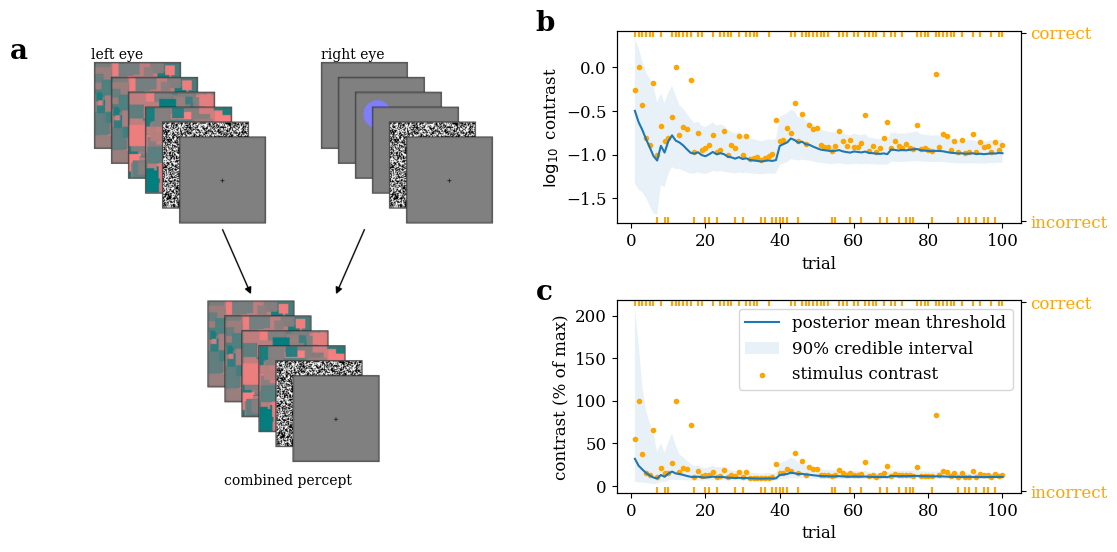

In [6]:
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

def add_label(ax, label):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - .2 * xscale, ymax, 
        label, size = 20, weight = 'bold'
    )

def plot_contrast(ax1, df, plot_scale):

    trial = df.trial
    if plot_scale == 'log10':
        mean = df.logC_mean
        upper = df.logC_95th_perc
        lower = df.logC_5th_perc
        contrast = np.log10(df.contrast)
    elif plot_scale == 'percent':
        mean = (10**df.logC_mean) * 100
        upper = (10**df.logC_95th_perc) * 100
        lower = (10**df.logC_5th_perc) * 100
        contrast = df.contrast * 100
        
    ax1.plot(trial, mean, label = 'posterior mean threshold')
    ax1.fill_between(df.trial, lower, upper, alpha = 0.1, label = '90% credible interval')
    ax1.scatter(trial, contrast, color = 'orange', label = 'stimulus contrast', marker = '.')
    ax1.set_xlabel('trial')
    if plot_scale == 'percent':
        ax1.set_ylabel('contrast (% of max)')
        #ax1.set_ylim(0, 100)
        ax1.legend(loc = 'upper right')
    elif plot_scale == 'log10':
        ax1.set_ylabel(r'$\log_{10}$ contrast')
    
    ax2 = ax1.twinx()
    ax2.set_ylim(-.01, 1.01)
    ax2.scatter(df.trial, df.correct, marker = '|', label = 'trial accuracy', color = 'orange')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['incorrect', 'correct'])
    ax2.tick_params(axis = 'y', labelcolor = 'orange')

fig = plt.figure(figsize = (12, 6))
gs = gridspec.GridSpec(2, 2, wspace = .3, hspace = .4)

# plot CFS illustration
left_ax = fig.add_subplot(gs[:, 0])
img = plt.imread('cfs.jpeg') # generated in experiment directory 
left_ax.imshow(img)
add_label(left_ax, 'a')
left_ax.axis('off')
# and add left/right labels
xmin, xmax = left_ax.get_xlim()
xscale = xmax - xmin
ymin, ymax = left_ax.get_ylim()
yscale = ymin - ymax
left_ax.text(
    0., ymax, 
    'left eye', size = 10
)
left_ax.text(
    .57*xscale, ymax, 
    'right eye', size = 10
)
left_ax.text(
    xmin + .33*xscale, ymin + .05*yscale, 
    'combined percept', size = 10
)


# plot on log scale
top_ax = fig.add_subplot(gs[0, 1])
plot_contrast(top_ax, df, 'log10')
add_label(top_ax, 'b')

# plot on linear scale
bottom_ax = fig.add_subplot(gs[1, 1])
plot_contrast(bottom_ax, df, 'percent')
add_label(bottom_ax, 'c')

if not os.path.exists('figures'):
    os.mkdir('figures')
f = os.path.join('figures', 'calibration-block.jpeg')
plt.savefig(f, dpi = 500, bbox_inches = 'tight')
plt.show()

In [7]:
from util.preprocessing import calc_overest_means, calc_detection_counts
from scipy.stats import fisher_exact

# check if detections exceed FPR as we will 
# in our manipulation check in main experiment
for sub in layout.get_subjects():
    df = layout.load_clock_data(sub)
    counts = calc_detection_counts(df)
    print(fisher_exact(counts).pvalue)

1.0
1.0
0.6153213874732861
1.0
0.6153213874732861


In [8]:
# but we only have a handful of pilot subjects,
# so let's also just print the detection rates
detection_rates = []
for sub in layout.get_subjects():
    df = layout.load(sub, 'masked')
    df = df[~df.practice]
    detection_rates.append(dict(
        subject = sub,
        catch_rate = df.aware[df.catch].mean(),
        hit_rate = df.aware[df.operant & (~df.catch)].mean(),
        false_alarm_rate = df.aware[(~df.operant) & (~df.catch)].mean()
    ))
rates = pd.DataFrame(detection_rates)
rates.head()

,subject,catch_rate,hit_rate,false_alarm_rate
0,01,0.9,0.075,0.075
1,02,0.7,0.000,0.000
2,03,1.0,0.075,0.025
3,04,1.0,0.000,0.025
4,05,1.0,0.025,0.075


In [9]:
rates.hit_rate - rates.false_alarm_rate

0    0.000
1    0.000
2    0.050
3   -0.025
4   -0.050
dtype: float64

In [10]:
all_means = []
for sub in layout.get_subjects():
    df = pd.concat([layout.load(sub, 'masked'), layout.load(sub, 'unmasked')])
    means = calc_overest_means(df) # Huber means
    all_means.append(means)
    #plt.plot([0, 1], [means['masked baseline'], means['masked operant']], color = 'firebrick')
    #plt.plot([0, 1], [means['unmasked baseline'], means['unmasked operant']], color = 'royalblue')
    #plt.xlim(-.5, 1.5)
df = pd.DataFrame(all_means)
print('Median unmasked shift:', np.median(df['unmasked operant'] - df['unmasked baseline']))
print('Masked shift:', np.median(df['masked operant'] - df['masked baseline']))

Median unmasked shift: 0.027716248584719386
Masked shift: -0.011063656975115126


In [11]:
df['unmasked operant'] - df['unmasked baseline']

0    0.057838
1    0.007724
2    0.027716
3    0.055016
4    0.004198
dtype: float64

In [12]:
from scipy.stats import ttest_1samp
ttest_1samp(df['unmasked operant'] - df['unmasked baseline'], popmean = 0, alternative = 'greater')

TtestResult(statistic=2.6921616047907397, pvalue=0.027267814804763438, df=4)

In [13]:
df['masked operant'] - df['masked baseline']

0   -0.164621
1   -0.003933
2   -0.007120
3   -0.011064
4   -0.043629
dtype: float64

In [14]:
ttest_1samp(df['masked operant'] - df['masked baseline'], popmean = 0)

TtestResult(statistic=-1.5116830978072318, pvalue=0.20514880949242345, df=4)

In [15]:
ttest_1samp(df['masked operant'] - df['masked baseline'], popmean = 0, alternative = 'greater')

TtestResult(statistic=-1.5116830978072318, pvalue=0.8974255952537883, df=4)

In [16]:
masked = df['masked operant'] - df['masked baseline']
unmasked = df['unmasked operant'] - df['unmasked baseline']
ttest_1samp(unmasked - masked, popmean = 0, alternative = 'greater')

TtestResult(statistic=2.040088799169369, pvalue=0.0554662100879169, df=4)